In [1]:
import cdf_sampler as cds
import numpy as np
from examples import gauss
import matplotlib.pyplot as plt

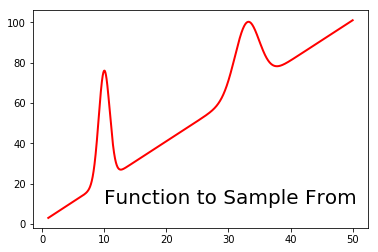

In [2]:
x = np.arange(1.,50.,.001)
y1= gauss(x,55.,10.,.5)
y2= gauss(x,33.,33.,1.1)
y3= 1.+2.*x
y = y1+y2+y3

f = plt.figure()
ax= f.add_subplot(111)
ax.plot(x,y,'r-',lw=2)
ax.annotate('Function to Sample From',xy=(10,10),fontsize=20)
plt.show()

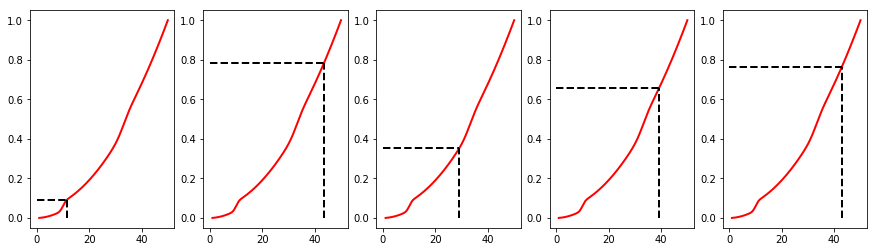

In [3]:
sampler = cds.cdf_sampler(x,y)

f = plt.figure(figsize=(15,4))
for i in range(5):
    tm   = np.random.uniform()
    tt   = np.where(np.abs(tm-sampler.cdf) == np.min(np.abs(tm-sampler.cdf)))
    tx   = x[tt[0]]
    tx   = tx[0]
    
    ax= f.add_subplot(1,5,i+1)
    ax.plot(x,sampler.cdf,'r-',lw=2)
    ax.plot([0,tx],[tm,tm],'k--',lw=2)
    ax.plot([tx,tx],[0,tm],'k--',lw=2)
plt.show()

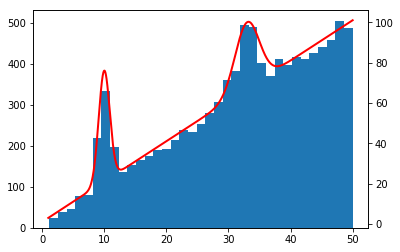

In [4]:
sampler.sample_n(10000)

f = plt.figure()
ax= f.add_subplot(111)
xa= ax.twinx()
ax.hist(sampler.sample,bins=35)
xa.plot(x,y,'r-',lw=2)
plt.show()

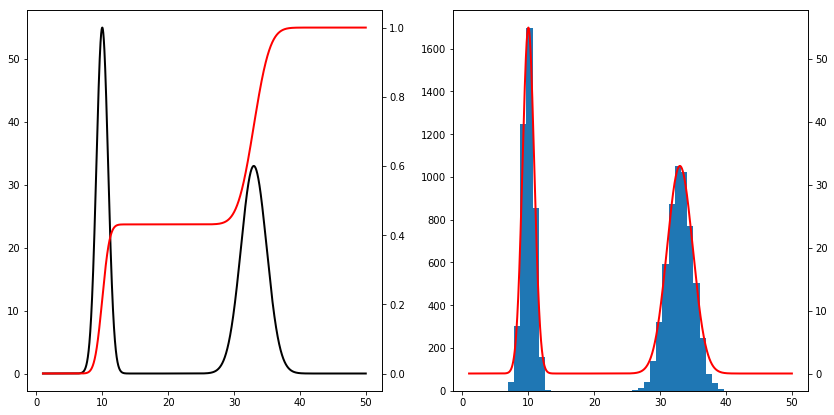

In [5]:
y = y1+y2
sampler = cds.cdf_sampler(x,y)
sampler.sample_n(10000)

f = plt.figure(figsize=(14,7))
ax= f.add_subplot(121)
ax.plot(x,y,'k-',lw=2)
xa=ax.twinx()
xa.plot(x,sampler.cdf,'r-',lw=2)

ax= f.add_subplot(122)
xa= ax.twinx()
ax.hist(sampler.sample,bins=35)
xa.plot(x,y,'r-',lw=2)
plt.show()